Context: https://www.kaggle.com/hellbuoy/car-price-prediction

In [419]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.feature_selection import RFE
import matplotlib.patches as mpatches

pd.set_option('display.max_columns', None)

In [420]:
# reading the dataset
cars = pd.read_csv("CarPrice_Assignment.csv")
cars.sample(5)

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
196,197,-2,volvo 244dl,gas,std,four,sedan,rwd,front,104.3,188.8,67.2,56.2,2935,ohc,four,141,mpfi,3.78,3.15,9.5,114,5400,24,28,15985.0
18,19,2,chevrolet impala,gas,std,two,hatchback,fwd,front,88.4,141.1,60.3,53.2,1488,l,three,61,2bbl,2.91,3.03,9.5,48,5100,47,53,5151.0
170,171,2,toyota tercel,gas,std,two,hardtop,rwd,front,98.4,176.2,65.6,52.0,2679,ohc,four,146,mpfi,3.62,3.50,9.3,116,4800,24,30,11199.0
124,125,3,plymouth duster,gas,turbo,two,hatchback,rwd,front,95.9,173.2,66.3,50.2,2818,ohc,four,156,spdi,3.59,3.86,7.0,145,5000,19,24,12764.0
174,175,-1,toyota celica gt,diesel,turbo,four,sedan,fwd,front,102.4,175.6,66.5,54.9,2480,ohc,four,110,idi,3.27,3.35,22.5,73,4500,30,33,10698.0


- How many rows/cols?

In [421]:
cars.shape

(205, 26)

$\to$ The dataset is small

- Are there any duplicates?

In [422]:
cars.duplicated().sum()

0

- Since the `car_ID` is useless, let's drop it

In [423]:
cars.drop('car_ID', axis=1, inplace=True)
cars.head()

,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


# Splitting

- Let's not know too much about the test & validation data by splitting the original data into 3 set (train/validation/test) before any further data exploration 

In [424]:
y_sr = cars["price"] 
X_df = cars.drop("price", axis=1)

In [425]:
X_train, X_test, y_train, y_test = train_test_split(X_df, y_sr, test_size=0.3, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=0)
X_train.shape, X_val.shape, X_test.shape

((128, 24), (15, 24), (62, 24))

# Data Exploration on train set

In [426]:
df_train = pd.concat([X_train, y_train], axis=1)
df_train.head()

,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
43,0,isuzu MU-X,gas,std,four,sedan,rwd,front,94.3,170.7,61.8,53.5,2337,ohc,four,111,2bbl,3.31,3.23,8.5,78,4800,24,29,6785.0
65,0,mazda glc,gas,std,four,sedan,rwd,front,104.9,175.0,66.1,54.4,2670,ohc,four,140,mpfi,3.76,3.16,8.0,120,5000,19,27,18280.0
77,2,mitsubishi lancer,gas,std,two,hatchback,fwd,front,93.7,157.3,64.4,50.8,1944,ohc,four,92,2bbl,2.97,3.23,9.4,68,5500,31,38,6189.0
72,3,buick skylark,gas,std,two,convertible,rwd,front,96.6,180.3,70.5,50.8,3685,ohcv,eight,234,mpfi,3.46,3.10,8.3,155,4750,16,18,35056.0
46,2,isuzu D-Max,gas,std,two,hatchback,rwd,front,96.0,172.6,65.2,51.4,2734,ohc,four,119,spfi,3.43,3.23,9.2,90,5000,24,29,11048.0


## Check each col's dtype

In [427]:
df_train.dtypes

symboling             int64
CarName              object
fueltype             object
aspiration           object
doornumber           object
carbody              object
drivewheel           object
enginelocation       object
wheelbase           float64
carlength           float64
carwidth            float64
carheight           float64
curbweight            int64
enginetype           object
cylindernumber       object
enginesize            int64
fuelsystem           object
boreratio           float64
stroke              float64
compressionratio    float64
horsepower            int64
peakrpm               int64
citympg               int64
highwaympg            int64
price               float64
dtype: object

Compared to **Data Dictionary - carprices.xlsx**, `symboling` should be converted to categorical col <font color='yellow'>(1)</font>

In [428]:
df_train['symboling'] = df_train['symboling'].astype('object')

## Examine numeric data

In [429]:
def missing_ratio(s):
    return s.isna().sum() * 100 / len(s)

num_cols = df_train.select_dtypes([np.int64, np.float64]).columns 
df_train[num_cols].agg([missing_ratio, pd.Series.min, pd.Series.max, pd.Series.nunique])

,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
missing_ratio,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0
min,86.6,144.6,61.8,47.8,1819.0,70.0,2.68,2.64,7.0,52.0,4150.0,13.0,16.0,5195.0
max,120.9,208.1,71.7,59.8,4066.0,326.0,3.80,4.17,23.0,262.0,6600.0,38.0,47.0,40960.0
nunique,46.0,64.0,36.0,40.0,112.0,36.0,33.00,32.00,27.0,46.0,18.0,25.0,27.0,122.0


No missing data; min & max vals are quite reasonable. 

- Since linear regression assumes the linear relationship b/w independent (`price`) & dependent cols. So let's check the Pearson correlation b/w `price` & other cols. Because visualizing using pair-plot for 14 numeric features are quite hard to read, a heatmap will be used instead 
- Also, linear regression is sensitive to multicollinearity. In other words, there should be no or little multicollinearity. So let's check for that, too

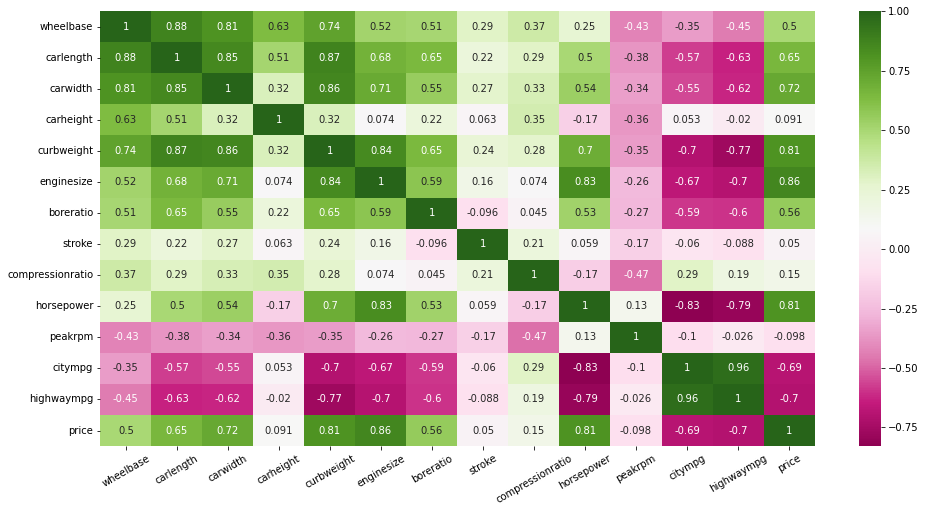

In [430]:
plt.figure(figsize=(16,8))

# cmap ref: https://python-graph-gallery.com/92-control-color-in-seaborn-heatmaps
ax = sns.heatmap(df_train[num_cols].corr(), cmap="PiYG", annot=True) 
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30);

Insights:
- `price` is highly correlated (positive & negative) with all the <font color='green'>green</font> & <font color='pink'>pink</font> cells in the last row since the corr > 0.5 (0.5 is my 'high correlation threshold'). These are the good features to keep, i.e. all the white cells should be eliminated <font color='yellow'>(2)</font>
- Multicollinearity: many independent variables are highly correlated (all 4 corners, those in green & bold pink, remember that this is a symetric matrix)

Let's check each numeric column's distribution

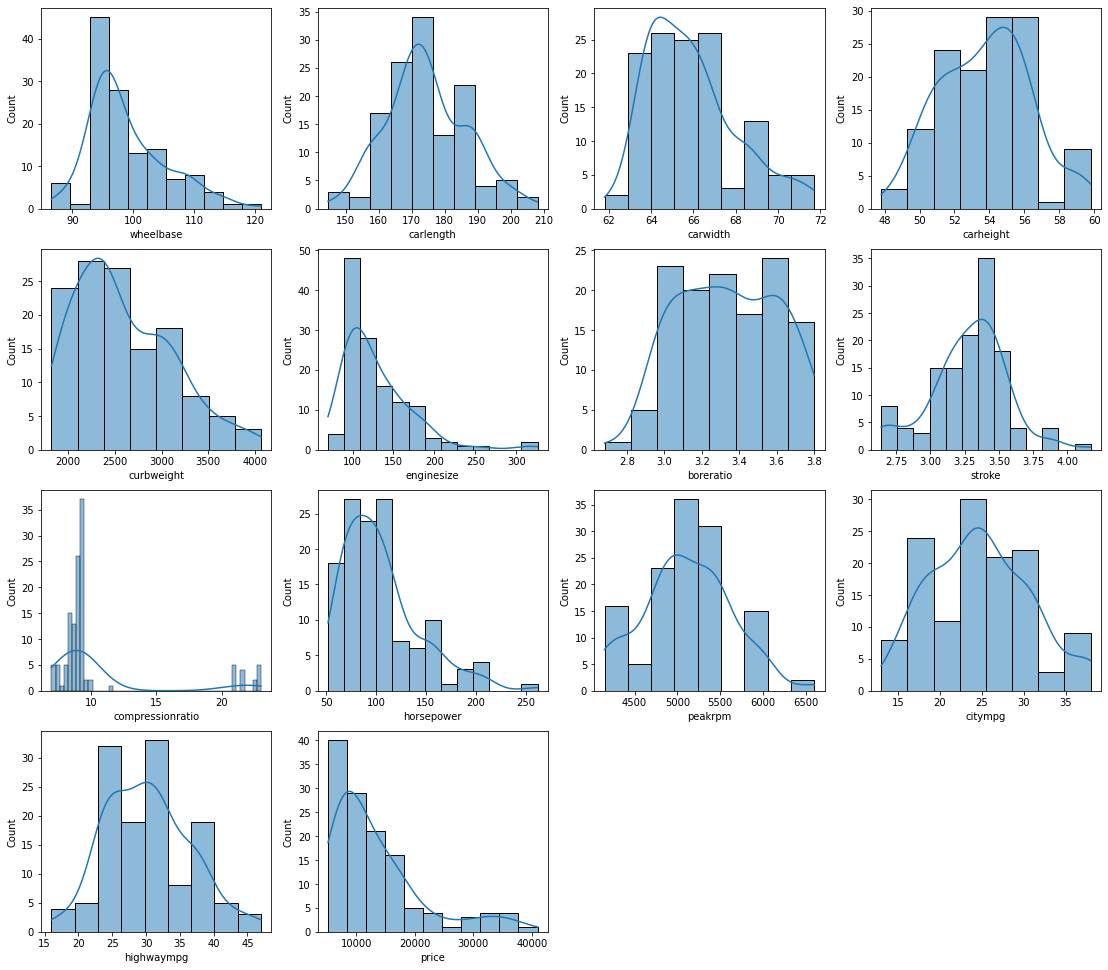

In [431]:
plt.figure(figsize=(19, 17))

for i in range(0, len(num_cols)):
    feat = num_cols[i]
    plt.subplot(4, 4, i+1)
    sns.histplot(df_train[feat], kde=True)

Insights:
- Skewness: wheelbase, carwidth, carheight, curbweight, enginesize, compressionratio, horsepower, peakrpm, citympg $\to$ use logarit to reduce the skewness <font color='yellow'>(4)</font>
- Outliers: enginesize, stroke, compressionratio, peakrpm, citympg, horsepower, boreratio. In the next cell, let's visualize the boxplots of all numeric cols to double check 

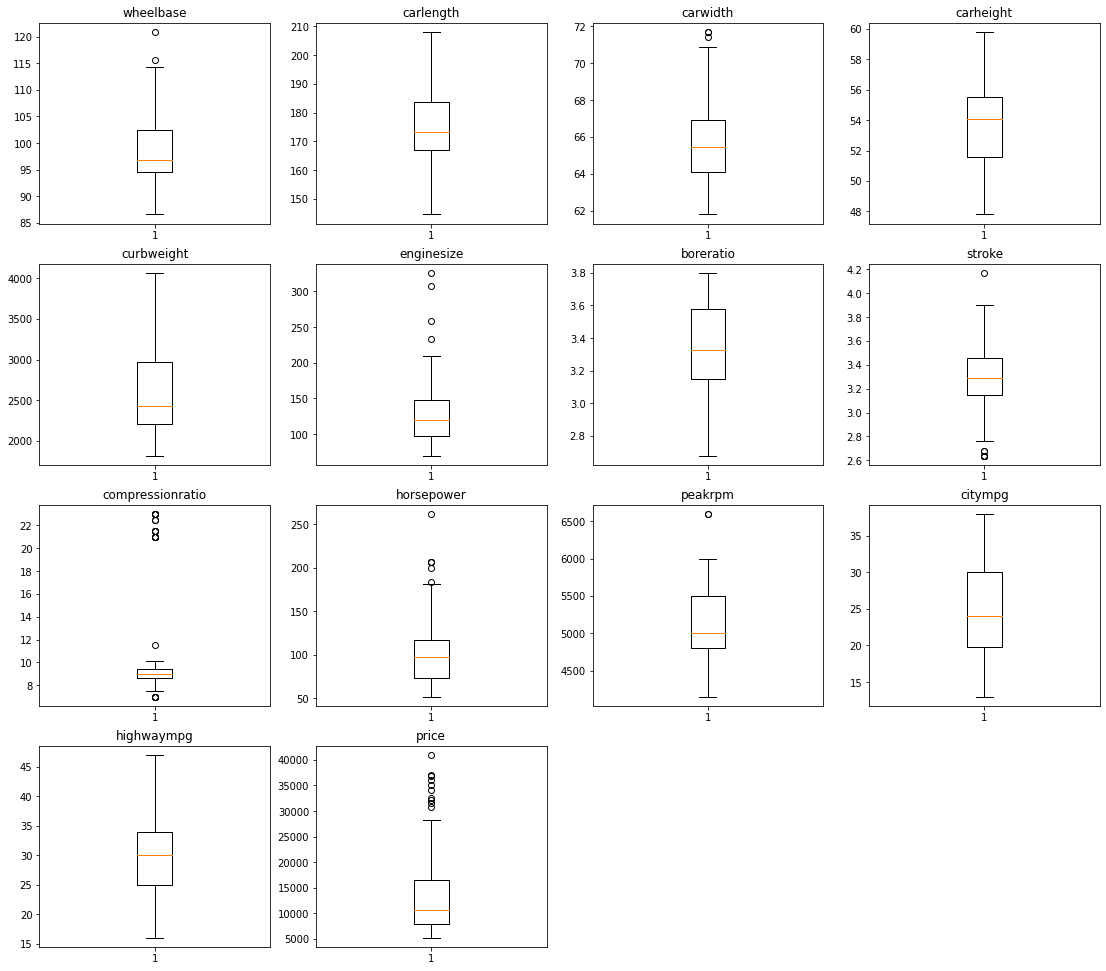

In [432]:
plt.figure(figsize=(19,17))
for i in range(len(num_cols)):
    plt.subplot(4,4,i+1)
    plt.boxplot(df_train[num_cols[i]])
    plt.title(num_cols[i])

It's obvious now that `enginesize`, `stroke`, `compressionratio` have more outliers than others (exclude `price` - target col). A simple way to reduce outliers is to take 3 standard deviation from the mean <font color='yellow'>(5)</font>

In [433]:
# outlier_cols = ['enginesize', 'stroke', 'compressionratio'] 
# original_shape = df_train.shape

# df_train = df_train[(np.abs(stats.zscore(df_train[outlier_cols])) < 3).all(axis=1)]
# original_shape, df_train.shape

## Examine categorical data

In [434]:
cat_cols = df_train.select_dtypes([object]).columns
df_train[cat_cols].agg([missing_ratio, pd.Series.nunique, pd.Series.unique])

,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,enginetype,cylindernumber,fuelsystem
missing_ratio,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
nunique,6,102,2,2,2,5,3,2,6,6,8
unique,"[0, 2, 3, 1, -1, -2]","[isuzu MU-X, mazda glc, mitsubishi lancer, bui...","[gas, diesel]","[std, turbo]","[four, two]","[sedan, hatchback, convertible, wagon, hardtop]","[rwd, fwd, 4wd]","[front, rear]","[ohc, ohcv, dohc, rotor, ohcf, l]","[four, eight, six, two, five, twelve]","[2bbl, mpfi, spfi, spdi, 1bbl, 4bbl, idi, mfi]"


- Check for balance among values of each feature

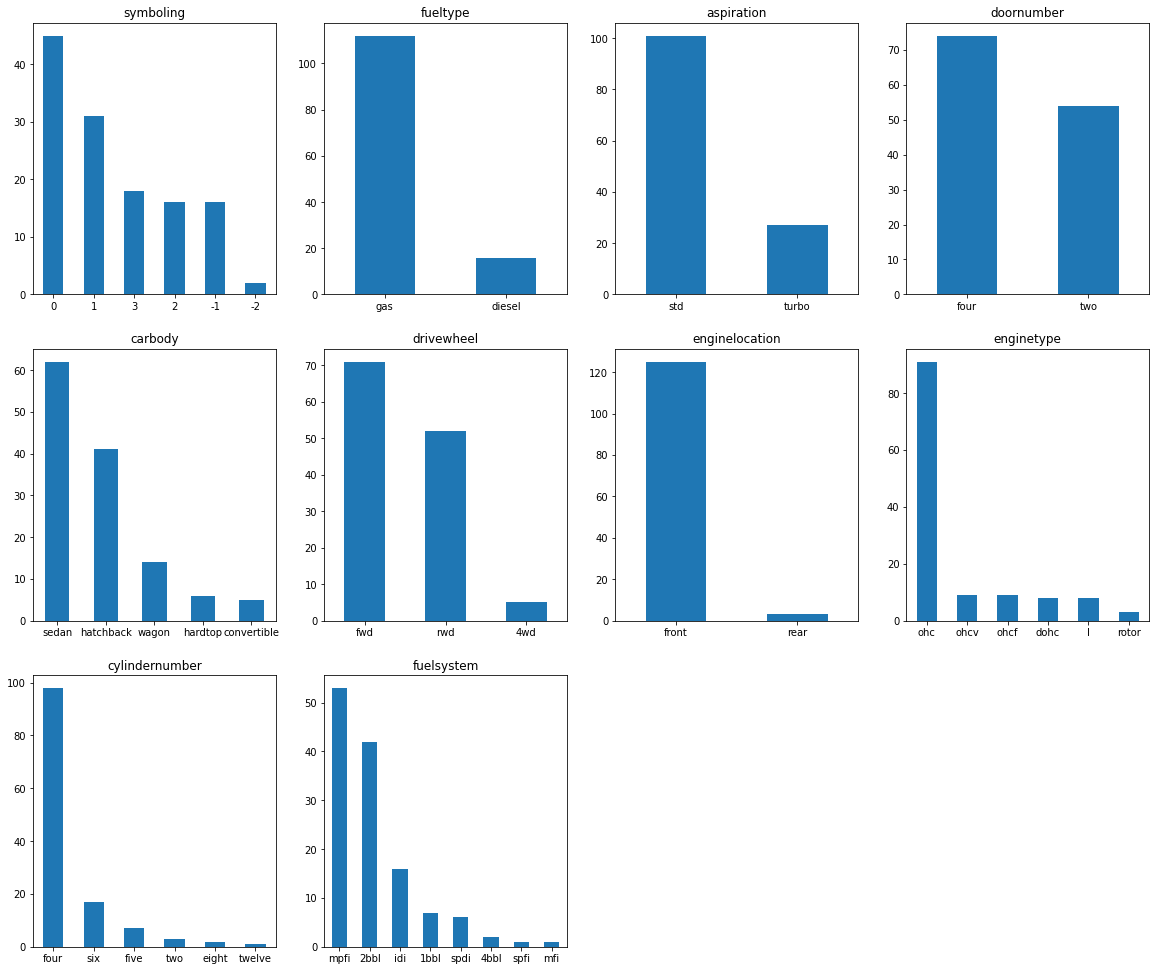

In [435]:
plt.figure(figsize=(20, 17))
cat_col_viz = cat_cols.drop('CarName') # no need to viz this

for i in range(0, len(cat_col_viz)):
    feat = cat_col_viz[i]
    plt.subplot(3, 4, i + 1) # subplot index from 1, so i + 1
    df_train[feat].value_counts().plot.bar(rot=0, title=feat)

- Let's examine a few vals in `CarName`: A quick glance at **CarPrice_Assignment.csv** show that the company name is what occurs before a space, e.g. alfa-romero in 'alfa-romero giulia', audi in 'audi 100 ls'. It seems like there's a need for creating a new column `CompanyName` since encoding 147 values in `CarName` will result in numerous new columns $\to$ prone to overfitting <font color='yellow'>(3)</font>

<AxesSubplot:>

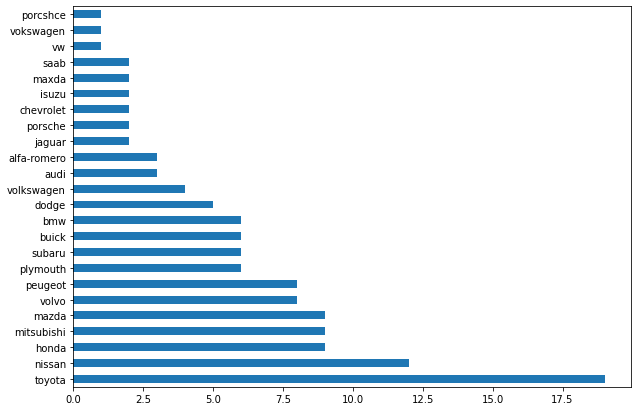

In [436]:
company_name = df_train['CarName'].apply(lambda x: x.split(" ")[0])
company_name.value_counts().plot.barh(figsize=(10,7))

## Conclusion
This stage lists 3 main problems that need to preprocess in the next stage:
1. `symboling` should be converted to categorical col
2. Manually do feature selection by eliminate `carheight`, `stroke`, `compressionratio`, `peakrpm`
3. Add a new column `CompanyName`
4. Skewness
5. Outliers

# Preprocessing

- Reduce outliers in `X_train`

In [437]:
# df_train is now less outliers
X_train = df_train.drop('price', axis=1)
y_train = df_train['price']
X_train.shape

(128, 24)

Beside dealing with the the first 3 preprocessing problems stated above in function `basic_preprocessing`, other preprocessing problems are:
- Encoding categorical values
- Scale numeric data

- First, let's prepare the function `basic_preprocessing` & define some globals 

In [438]:
def basic_preprocessing(X_df):
    '''this function give solutions to 3 above-mentioned problems'''
    X_out = X_df.copy()
    X_out['symboling'] = X_out['symboling'].astype('object') # (1)
    X_out['CompanyName'] = X_out['CarName'].apply(lambda x: x.split(" ")[0]) # (3)
    X_out.drop('CarName', axis=1, inplace=True)    
    
    return X_out

skewed_cols = ['wheelbase', 'carheight', 'carwidth', 'curbweight', 'enginesize', 'horsepower', 'citympg', 'compressionratio', 'peakrpm']

cate_cols = cat_cols.drop('CarName').tolist()
cate_cols.append('CompanyName')

# nume_cols = num_cols.drop(['carheight', 'stroke', 'compressionratio', 'peakrpm', 'price']).tolist()

In [439]:
len(cate_cols + num_cols.tolist())
cate_cols

['symboling',
 'fueltype',
 'aspiration',
 'doornumber',
 'carbody',
 'drivewheel',
 'enginelocation',
 'enginetype',
 'cylindernumber',
 'fuelsystem',
 'CompanyName']

- Then, build a `preprocess_pipeline`. Note that `handle_unknown='ignore'` is turned because for any categorical col, when `preprocess_pipeline` meets some new & unseen values, the default machanic of `OneHotEncoder` is to raise the errors

In [440]:
preprocess_pipeline = Pipeline([
    ('basic_preprocessing', FunctionTransformer(basic_preprocessing)),
    ('col_transform', ColumnTransformer([('cat_transform', OneHotEncoder(handle_unknown='ignore'), cate_cols)
                                        #  ('skewed_transform', FunctionTransformer(np.log1p), skewed_cols)
                                        ], 
                                        remainder='passthrough')),
    ('scaler', StandardScaler(with_mean=False))
])

preprocessed_X_train = preprocess_pipeline.fit_transform(X_train)

# ML models

Brief: 2 main algorithms used are pure linear regression (without handling multicolinearity) & linear regression with RFE (Recursive Feature Elimination - this is an auto feature selection implemented by sklearn). At the end, I will handle multicolinearity manually and then evaluate all the existing models

- First, let's preprocess `X_val` & `X_test`

In [441]:
preprocessed_X_val = preprocess_pipeline.transform(X_val)
preprocessed_X_test = preprocess_pipeline.transform(X_test)

- Second, let's build the train_predict procedure

In [442]:
def train_predict(learner, X_train, y_train, X_test, y_test): 
   '''
   inputs:
      - learner: the estimator
      - X_train: features training set (assume preprocessed)
      - y_train: income training set
      - X_test: features testing set (assume preprocessed)
      - y_test: income testing set
   output: a dictionary with each key:
      - mean_rmse & std_rmse: rmse scores from running the estimator on cross validation
      - r2_train, r2_test: r2 accuracy on train & test set
   '''
   results = {}
   
   # Fitting (training) phase
   learner = learner.fit(X_train, y_train)
   
   # prediction phase
   y_test_pred = learner.predict(X_test)
   y_train_pred = learner.predict(X_train)
         
   # cross validation score
   scores_train = cross_val_score(learner, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
   rmse = np.sqrt(-scores_train) # this is an array containing [cv] rmse scores of [cv] training times
   results['mean_rmse'] = rmse.mean() # give an estimate
   results['std_rmse'] = rmse.std() # how precise the estimate is
   
   results['r2_train'] = r2_score(y_train, y_train_pred)
   results['r2_test'] = r2_score(y_test, y_test_pred)
      
   return results

- Also, `models` to keep track of all the algorithms' performances

In [443]:
models = {}

## 1. Linear Regression

In [444]:
lm = LinearRegression()

models[lm.__class__.__name__] = train_predict(lm, preprocessed_X_train, y_train, preprocessed_X_val, y_val)
models

{'LinearRegression': {'mean_rmse': 766452731837827.2,
  'std_rmse': 1048826424731635.2,
  'r2_train': 0.9785654110012105,
  'r2_test': 0.9208761273117603}}

$\to$ It's a bit overfitting

## 2. Linear Regression + RFE

In [445]:
params = {'n_features_to_select': np.arange(6,21)}
grid_search = GridSearchCV(RFE(LinearRegression()), params).fit(preprocessed_X_train, y_train)

grid_search.best_score_

-4.5645362189920055e+23

In [446]:
best_rfe = grid_search.best_estimator_
models[best_rfe.__class__.__name__] = train_predict(best_rfe, preprocessed_X_train, y_train, preprocessed_X_val, y_val)
models[best_rfe.__class__.__name__]

{'mean_rmse': 3908539170681549.0,
 'std_rmse': 4971457848509218.0,
 'r2_train': 0.861680953259752,
 'r2_test': 0.9439488822505773}

$\to$ `r2_train` < `r2_test`: this can be caused by the fact that #data_points in val set is smaller than those in train set

In [447]:
best_rfe.support_

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False,  True,  True,
        True, False, False, False, False,  True,  True, False, False,
       False,  True, False,  True,  True,  True,  True, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False])

## 3. Handle multicolinearity manually
- Remember that in previous steps, the problem of multicolinearity is not fully resolved. So now, let's plot the correlation plot again between existing num_cols in `preprocessed_X_train` 

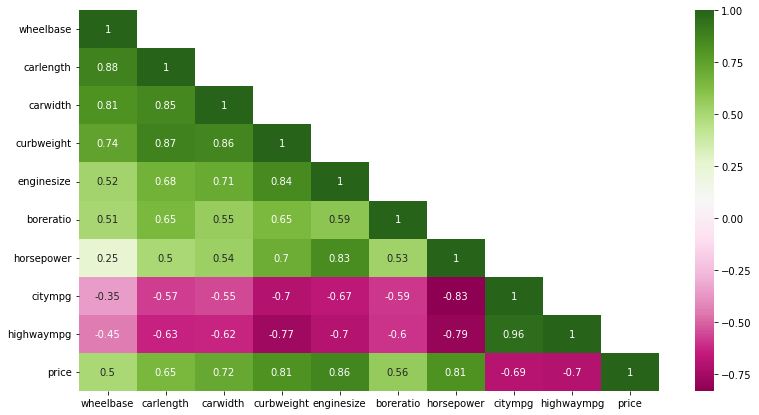

In [448]:
corr = df_train[nume_cols + ['price']].corr()
matrix = np.triu(corr, k=1) # upper triangle (exclude the main diagional)

plt.figure(figsize=(13,7))
ax = sns.heatmap(corr, cmap="PiYG", annot=True, mask=matrix) 
ax.set_xticklabels(ax.get_xticklabels(), rotation = 0)
ax.set_yticklabels(ax.get_yticklabels(), rotation = 0);

What I can do to reduce multicolinearity:
- wheelbase can be infered from carlength, so I will eliminate wheelbase
- cararea = carlength * carwidth
- totalmpg = citympg + highwaympg
Let's create a new function to handle these new transformations add add it to the current pipeline

In [449]:
def col_adder_dropper(X_df):
    X_out = X_df.copy()
    
    # adder
    X_out['cararea'] = X_out['carlength'] * X_out['carwidth']
    X_out['totalmpg'] = X_out['citympg'] + X_out['highwaympg']
    # dropper
    X_out.drop(['wheelbase', 'carlength', 'carwidth', 'citympg', 'highwaympg'], axis=1, inplace=True)
    return X_out

to_del = ['wheelbase', 'carwidth', 'citympg']
skewed_cols_2 = [item for item in skewed_cols if item not in to_del]
skewed_cols_2

['carheight',
 'curbweight',
 'enginesize',
 'horsepower',
 'compressionratio',
 'peakrpm']

In [450]:
preprocess_pipeline_2 = Pipeline([
    ('basic_preprocessing', FunctionTransformer(basic_preprocessing)),
    ('col_adder_dropper', FunctionTransformer(col_adder_dropper)), # add this line to the original pipeline
    ('col_transform', ColumnTransformer([('cat_transform', OneHotEncoder(handle_unknown='ignore'), cate_cols),
                                         ('num_transform', FunctionTransformer(np.log1p), skewed_cols_2)], 
                                        remainder='passthrough')),
    ('scaler', StandardScaler(with_mean=False))
])

preprocessed_X_train_2 = preprocess_pipeline_2.fit_transform(X_train)
preprocessed_X_val_2 = preprocess_pipeline_2.transform(X_val)

In [451]:
lm2 = LinearRegression()
models[lm2.__class__.__name__ + '2'] = train_predict(lm2, preprocessed_X_train_2, y_train, preprocessed_X_val_2, y_val)
models[lm2.__class__.__name__ + '2']

{'mean_rmse': 5805.947193119984,
 'std_rmse': 4459.449034484863,
 'r2_train': 0.975024170111309,
 'r2_test': 0.9018729027411149}

# Evaluation

In [452]:
df = pd.DataFrame.from_dict(models).T
df

,mean_rmse,std_rmse,r2_train,r2_test
LinearRegression,7.664527e+14,1.048826e+15,0.978565,0.920876
RFE,3.908539e+15,4.971458e+15,0.861681,0.943949
LinearRegression2,5.805947e+03,4.459449e+03,0.975024,0.901873


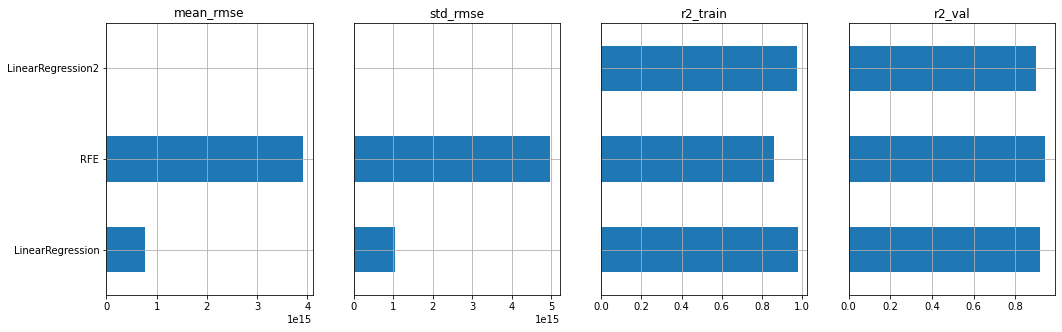

In [453]:
plt.figure(figsize=(17,5))

for i, feat in enumerate(list(df)):
    plt.subplot(1,4,i+1)
    df[feat].plot.barh(title = feat if feat != 'r2_test' else 'r2_val')
    plt.grid(visible=True)
    
    if i >= 1:
        plt.tick_params(
        axis='y',       
        which='both',   
        left=False,     
        right=False,    
        labelleft=False)

Insights:
- Even though RFE has a great `r2_val`, it has the highest std_rmse (or variability), which means that RFE is less trusted than the the other 2 Linear Regression
- The results for 2 Linear Regression approaches from 4 charts are nearly the same, except for `std_rmse`, which shows that `LinearRegression2` (handle multicolinearity) is more trusted than a pure Linear Regression. This implies that we should take multicolinearity into consideration when working with linear regression problems

In [454]:
from scipy import sparse

final_X_train = sparse.vstack((preprocessed_X_train_2, preprocessed_X_val_2))
final_y_train = pd.concat((y_train, y_val))
final_X_train.shape, final_y_train.shape

((143, 79), (143,))

- Retrain with the best model: concat the training & validation set into a final single training set & validate on the test set

In [456]:
lm2 = LinearRegression()
models[lm2.__class__.__name__ + '2'] = train_predict(lm2, final_X_train, final_y_train, preprocessed_X_test, y_test)
models[lm2.__class__.__name__ + '2']

{'mean_rmse': 3116.2040014385734,
 'std_rmse': 1507.2549731472295,
 'r2_train': 0.9591013613295396,
 'r2_test': 0.8577145712257683}

- Calc r2_score

In [ ]:
y_test_pred = lm2.predict(preprocessed_X_test)
r2_score(y_test, y_test_pred)

0.8527756444004222